---
<h1><center> Needle in a Haystack - The Fraud Detection Capstone Project </center></h1>
<h2><center> Marketa Mikulkova </center></h2>

--- 

## Abstract

The ultimate goal of this project is to develop a counter-solution to account takeover attacks in payment services. The primary goal is to build a model that could identify patterns in data and spot fraudulent transactions with the highest hit-rate possible. The secondary goal is to find use of it for businesses based on their risk-aversion level:
- Send suspicious transactions to further human investigation, or
- Completely block flagged transactions

## Source of data

The lack of publicly available data on financial transactions was addressed by group TESTIMON when they introduced a simulator PaySim that creates synthetic transaction data based on a sample of real transactions from a mobile money service implemented in an unspecified African country. The synthetic dataset resembles the normal operation of transactions with injected malicious behavior. 

The data is available on Kaggle under the name Synthetic Financial Datasets For Fraud Detection. It was published by TESTIMON which is the Digital Forensics Research Group from NTNU in Gjøvik, Norway. There are various academic papers published by authors of the data simulator that help to understand what the data represent. 
https://www.kaggle.com/ntnu-testimon/paysim1#PS_20174392719_1491204439457_log.csv

## Assumptions and Considerations

### 1) Class-imbalance

Presence of fraudulent transactions tends to be rare and it is the case for given dataset as well. When trying to build the best model, I considered three different scenarios:
- oversampled train set & oversampled test set
- non-oversampled train set & non-oversampled test set
- oversampled train set & non-oversampled test set

Even though the models' performance on oversampled train and test sets was better, I decided to maintain the original proportion of fraudulent to genuine transactions for two reasons:
- the goal is to find a model that could be used in real-world conditions
- in case of unlabeled data, it wouldn't be clear which transactions to oversample

### 2)  Categorical variables with high cardinality

Two of the original features are counterparties involved in the transaction, namely, *'nameOrig'* being the unique identifier of the client where transaction originated, and the *'nameDest'* identifying the recipient of given transaction. 

My initial approach was to encode these high-cardinality variables using Weight of Evidence encoding algorithm that is based on correlation of the categorical attributes to be encoded to the target variables. The assigned/encoded numerical value is a function of number of records with the categorical value in question and how they break down between positive and negative class attribute values. Additionally, total number of records with the positive and negative class labels are also taken into account. For class imbalanced data, Weight of Evidence algorithm should work better than let's say Target or Leave-one-out encoder.

Source of inspiration: https://pkghosh.wordpress.com/2017/10/09/combating-high-cardinality-features-in-supervised-machine-learning/

I also wanted to use the *'nameOrig'* and the *'nameDest'* as a common key for identifying transactions where cash-out followed transfer, since the type of fraud present in this dataset is account takeover, but my assumption proved to be incorrect, at least for this dataset, and I couldn't link intuitively connected transactions.    

The final decision was not to use *'nameOrig'* and *'nameDest'* due to the fact that fraudsters would most probably not use the same accounts for withdrawing money from the system repetitively.  

### 3) Various models

For each of the oversampled/not-oversampled and encoded/not-encoded scenarios, 5 different classifier models or ensembles of models were used:
- logistic regression
- decision tree
- random forest
- XGBoost using decision tree as a base model
- multi-layer perceptron 

The random forest model and the XGBoost delivered the best results, hence the notebook focuses only on the two beforehand mentioned. 

# Process:

## Packages and libraries

First, the libraries to be used need to be imported.

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
#from imblearn.over_sampling import ADASYN 
#from category_encoders.woe import WOEEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier 
#from sklearn.neural_network import MLPClassifier
from sklearn import pipeline
from sklearn import preprocessing
#from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from tempfile import mkdtemp
import pickle
import warnings
warnings.filterwarnings('ignore')

## Import and data cleaning

The following cell contains path to the full, 6.3 million-entries dataset. To find the best model while maintaining the run-time feasible, a 10% subset of data was used to prototype. The results were then verified on 80% and 100% of the original data and will be shown towards the end of the notebook. 

In [170]:
# the full dataset can be downloaded from the Kaggle link mentioned in Source of data section
ps = pd.read_csv('.../paysim.csv')
ps.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
# original dataset is rather large to be processed
ps.shape

(6362620, 11)

In [4]:
# class imbalance --> the percentage of fraudulent transactions in the entire dataset
print(round(sum(ps['isFraud'])/ps['isFraud'].count()*100,3),'%')

0.129 %


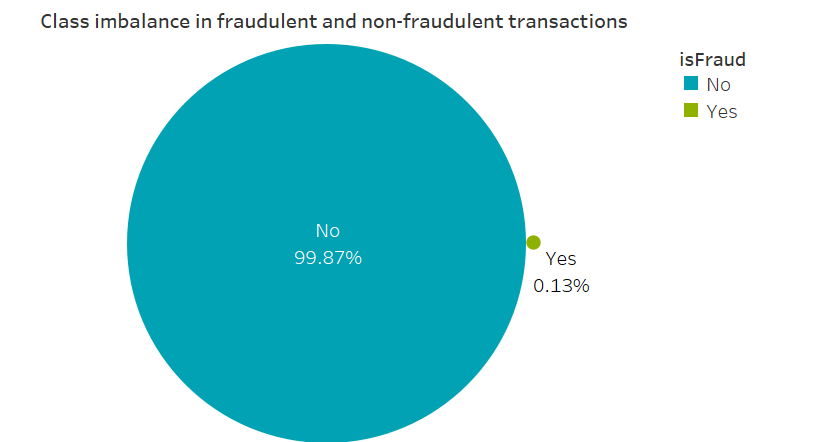

In [5]:
# 'stratify' flag to preserve the class imbalance 
from sklearn.model_selection import train_test_split
ps_subset, ps_rest = train_test_split(ps,test_size=0.1,random_state=38, stratify=ps['isFraud'])

# double-checking if the original ratio of fraudulent transactions stayed the same
print(round(sum(ps_subset['isFraud'])/ps_subset['isFraud'].count()*100,3),'%')
print(round(sum(ps_rest['isFraud'])/ps_rest['isFraud'].count()*100,3),'%')

0.129 %
0.129 %


In [6]:
# saving the subset
ps_subset.to_csv('c:/MSI/BrainStation/Data Science FT/Capstone project/ps_subset.csv')

In [2]:
# reading the 10% subset for faster processing and model prototyping 
ps_subset = pd.read_csv('c:/MSI/BrainStation/Data Science FT/Capstone project/ps_subset.csv',delimiter=',',index_col=0)

In [3]:
display(ps_subset.isna().sum())
ps_subset.describe()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,636262.000000,6.362620e+05,6.362620e+05,6.362620e+05,6.362620e+05,6.362620e+05,636262.000000,636262.0
mean,243.286706,1.785372e+05,8.295293e+05,8.508695e+05,1.101647e+06,1.224799e+06,0.001290,0.0
std,142.251118,5.768838e+05,2.872531e+06,2.908142e+06,3.356923e+06,3.612651e+06,0.035898,0.0
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,156.000000,1.334686e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
50%,238.000000,7.440781e+04,1.404800e+04,0.000000e+00,1.332614e+05,2.157892e+05,0.000000,0.0
75%,334.000000,2.084907e+05,1.072740e+05,1.441518e+05,9.486033e+05,1.116961e+06,0.000000,0.0
max,742.000000,5.560711e+07,5.958504e+07,4.958504e+07,3.555534e+08,3.553814e+08,1.000000,0.0


None of the values is missing. The *'isFlaggedFraud'* column has no variance and it wouldn't be very useful for deciphering patterns, therefore, it can be dropped.

In [4]:
ps_subset = ps_subset.drop(columns=['isFlaggedFraud'])

In [5]:
# setting uniform column names (Org x Orig) 
ps_subset = ps_subset.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

## EDA and Feature engineering 

The following section covers basic Exploratory Data Analysis (EDA) and intuitive feature engineering based on the revealed information. 

In [6]:
# Preparing for feature creation ('correctAmount' and 'amtIsCorrect'). To avoid rounding errors, integer values are used 
# Multiplying by 100 to later divide by 100 (due to certain discrepancies in the dataset)
list_of_columns = ['oldBalanceOrig','newBalanceOrig','oldBalanceDest','newBalanceDest']
for i in list_of_columns:
    ps_subset[i] = (ps_subset[i]*100).astype(dtype='int64')

In [7]:
# creating new 'correctAmount' column to be later filled with calculated amount depending on transaction type
ps_subset['correctAmount'] = 0
ps_subset['amount']=round(ps_subset['amount']).astype(dtype='int64')

Three sub-dataframes are created to have the *'correctAmount'* column filled with calculated values using columns that were observed as being relevant for each type of transaction. 

In [8]:
# 'amount' and affected 'balance' columns vary depending on the type of transaction
payment_debit_df = ps_subset[(ps_subset['type']=='PAYMENT') | (ps_subset['type']=='DEBIT')].copy()
payment_debit_df['correctAmount'] = round((payment_debit_df['oldBalanceOrig']-payment_debit_df['newBalanceOrig'])/100).astype(dtype='int64')

cashout_transfer_df = ps_subset[(ps_subset['type']=='CASH_OUT') | (ps_subset['type']=='TRANSFER')].copy()
cashout_transfer_df['correctAmount'] = round((cashout_transfer_df['newBalanceDest']-cashout_transfer_df['oldBalanceDest'])/100).astype(dtype='int64')

cashin_df = ps_subset[(ps_subset['type']=='CASH_IN')].copy()
cashin_df['correctAmount'] = round((cashin_df['oldBalanceDest']-cashin_df['newBalanceDest'])/100).astype(dtype='int64')

In [9]:
ps_subset_amt = pd.concat([payment_debit_df,cashout_transfer_df,cashin_df],axis=0)

In [10]:
# dividing by 100 to get original 'balance' values
for i in list_of_columns:
    ps_subset_amt[i] = round((ps_subset_amt[i]/100)).astype(dtype='int64')

Another feature, *'amtIsCorrect'*, comparing the calculated and the reported amount, is added.   

In [11]:
# creating second new variable 'amtIsCorrect' comapring the original reported 'amount' with amount calculated from 
    # 'new/oldBalance' columns 
ps_subset_amt['amtIsCorrect'] = np.where(ps_subset_amt['amount'] == ps_subset_amt['correctAmount'],1,0)

Basic overview of the new feature *'amtIsCorrect'* being able to potentially separate fraudulent from genuine transactions: 

In [12]:
types_of_transactions = ['PAYMENT', 'DEBIT', 'CASH_OUT', 'TRANSFER', 'CASH_IN'] 
correct_amt_list = []
for i in types_of_transactions: 
    correct_amt = ps_subset_amt[(ps_subset_amt['type']==i) & (ps_subset_amt['amtIsCorrect']==1) & (ps_subset_amt['isFraud']==0)].count()/ps_subset_amt[(ps_subset_amt['type']==i)].count()
    correct_amt_list.append(correct_amt[0]*100)
    print(f' In', round(correct_amt[0]*100,2),'% of cases the amount is correct when type of transaction is',i,) 

 In 48.72 % of cases the amount is correct when type of transaction is PAYMENT
 In 71.48 % of cases the amount is correct when type of transaction is DEBIT
 In 90.0 % of cases the amount is correct when type of transaction is CASH_OUT
 In 89.09 % of cases the amount is correct when type of transaction is TRANSFER
 In 73.8 % of cases the amount is correct when type of transaction is CASH_IN


In [13]:
types_of_transactions = ['PAYMENT', 'DEBIT', 'CASH_OUT', 'TRANSFER', 'CASH_IN'] 
correct_amt_list_fraud_yes = []
for i in types_of_transactions: 
    correct_amt_fraud_yes = ps_subset_amt[(ps_subset_amt['type']==i) & (ps_subset_amt['amtIsCorrect']==1) & (ps_subset_amt['isFraud']==1)].count()/ps_subset_amt[(ps_subset_amt['type']==i)].count()
    correct_amt_list_fraud_yes.append(correct_amt_fraud_yes[0]*100)
    print(f' In', round(correct_amt_fraud_yes[0]*100,2),'% of cases the amount is correct when type of transaction is',i,) 

 In 0.0 % of cases the amount is correct when type of transaction is PAYMENT
 In 0.0 % of cases the amount is correct when type of transaction is DEBIT
 In 0.18 % of cases the amount is correct when type of transaction is CASH_OUT
 In 0.0 % of cases the amount is correct when type of transaction is TRANSFER
 In 0.0 % of cases the amount is correct when type of transaction is CASH_IN


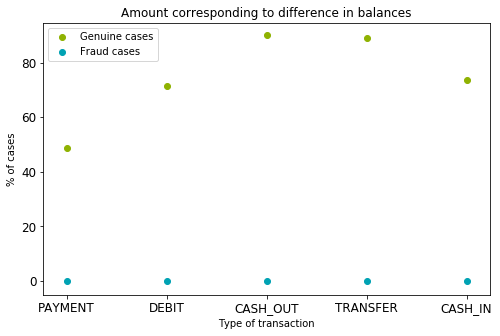

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.tick_params(labelsize='large')
plt.scatter(types_of_transactions,correct_amt_list, label='Genuine cases',c='#8fb202')
plt.scatter(types_of_transactions,correct_amt_list_fraud_yes, label='Fraud cases',c='#00a2b3')
plt.title('Amount corresponding to difference in balances')
plt.xlabel('Type of transaction')
plt.ylabel('% of cases')
plt.legend(loc='upper left')
plt.show();

In [15]:
# creating three new features to address absolute value of difference between balances and reported amount 
    # and to distinguish where is the discrepancy coming from, whether the originator or the recipient of the transaction
ps_subset_amt['diffBalanceAmtOrig']=ps_subset_amt['oldBalanceOrig']-ps_subset_amt['newBalanceOrig']-ps_subset_amt['amount']
ps_subset_amt['diffBalanceAmtDest']=ps_subset_amt['newBalanceDest']-ps_subset_amt['oldBalanceDest']-ps_subset_amt['amount']
ps_subset_amt['diffCorrectAmtAmt']=ps_subset_amt['correctAmount']-ps_subset_amt['amount']

In [16]:
payment_df = ps_subset_amt[ps_subset_amt['type']=='PAYMENT'].copy()
rest_of_trans_df = ps_subset_amt[ps_subset_amt['type']!='PAYMENT'].copy()

In [17]:
# payment goes through merchant and their balances don't show in this dataset by default 
payment_df['diffBalanceAmtDest'] = 0
payment_df['diffCorrectAmtAmt'] = 0
ps_subset_amt = pd.concat([payment_df,rest_of_trans_df],axis=0,sort=False)

The only two types of transactions where the fraud is happening are Transfer followed by Cash-out. It is logical given the type of fraud present in this dataset and the sequence the money is taken out of the mobile money platform. The number of cases is almost equal - not all the transfered money was cashed-out at once (might have been due to potential withdrawal limits). 

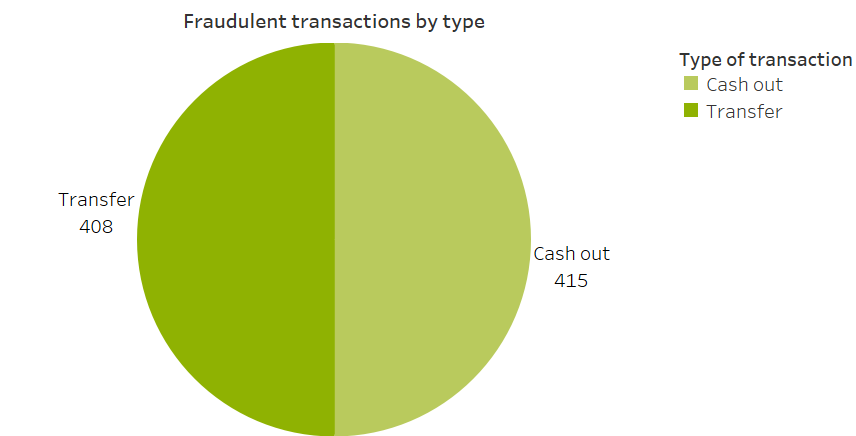

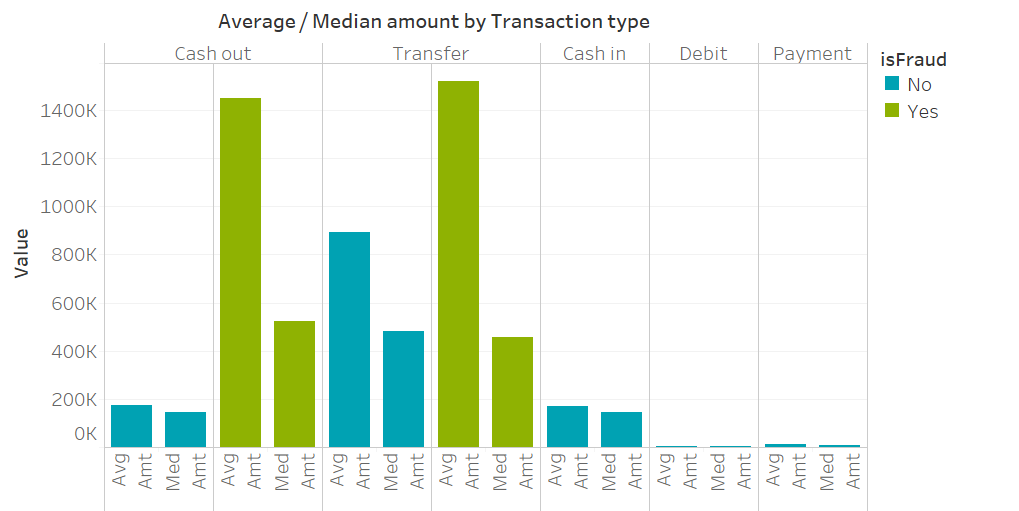

Given the difference in median and average amount for genuine and fraudulent transactions, additional new features are created in hope they will help in identifying patterns:
- flag for cash-out being greater than 200,000 currency units
- flag for transfer greater than 1,000,000 currency units

In [18]:
ps_subset_amt['COGreaterThan200000'] = 0
ps_subset_amt['TRGreaterThan1000000'] = 0
cashout_df = ps_subset_amt[ps_subset_amt['type']=='CASH_OUT'].copy()
transfer_df = ps_subset_amt[ps_subset_amt['type']=='TRANSFER'].copy()
rest_df = ps_subset_amt[(ps_subset_amt['type']=='DEBIT')|(ps_subset_amt['type']=='PAYMENT')|(ps_subset_amt['type']=='CASH_IN')].copy()
cashout_df['COGreaterThan200000'] = np.where(cashout_df['amount']>200000,1,0)
transfer_df['TRGreaterThan1000000'] = np.where(transfer_df['amount']>1000000,1,0)
ps_subset_amt = pd.concat([cashout_df,transfer_df,rest_df],axis=0,sort=False)

The next sub-section gives an overview of the strength of linear relationship for each pair of features. One heatmap is for fraudulent and one for genuine transactions. 

In [19]:
corr_mat_fraud = ps_subset_amt[ps_subset_amt['isFraud']==1].corr()
corr_mat_genuine = ps_subset_amt[ps_subset_amt['isFraud']==0].corr()
corr_mat_fraud = corr_mat_fraud.corr()
corr_mat_genuine = corr_mat_genuine.corr()

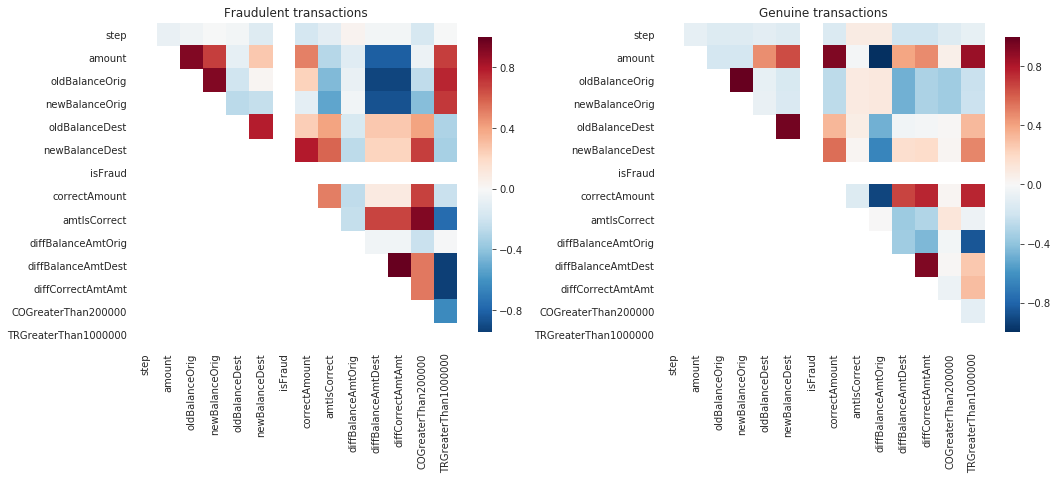

In [20]:
import seaborn as sns
mask_fraud = np.zeros_like(corr_mat_fraud)
mask_fraud[np.tril_indices_from(mask_fraud)] = True
fig = plt.figure(figsize=(15,12))
with sns.axes_style("white"):
    ax1 = fig.add_subplot(121)
    ax1 = sns.heatmap(corr_mat_fraud, mask=mask_fraud, square=True,center=0,cmap='RdBu_r',cbar_kws={"shrink": 0.35})
    ax1.set_title('Fraudulent transactions')
    
mask_genuine = np.zeros_like(corr_mat_genuine)
mask_genuine[np.tril_indices_from(mask_genuine)] = True
with sns.axes_style("white"):
    ax2 = fig.add_subplot(122)
    ax2 = sns.heatmap(corr_mat_genuine, mask=mask_genuine, square=True,center=0,cmap='RdBu_r',cbar_kws={"shrink": 0.35})
    ax2.set_title('Genuine transactions')
plt.tight_layout()

Different level of correlations for each subset of transactions (fraudulent/non-fraudulent) is promising to give the models guidance when deciphering well-hidden patterns.  

## Introducing dummy variables

In order to be able to work with categorical data, the majority of models needs to be fed with a numerical representation of such data. In this case, one-hot encoding will be used to replace the *'type'* of transaction. 

In [21]:
# moving 'isFraud' to the front
cols = list(ps_subset_amt)
cols.insert(0, cols.pop(cols.index('isFraud')))
# using loc to assign new order
ps_subset_amt = ps_subset_amt.loc[:, cols]

In [22]:
type_dummies = pd.get_dummies(ps_subset_amt['type'])[['CASH_OUT','TRANSFER','DEBIT','PAYMENT','CASH_IN']] 
ps_subset_amt = pd.concat([ps_subset_amt, type_dummies], axis = 1)
ps_subset_amt.drop(columns=['type'],inplace=True)

## Train / test split

The dataset will be split in two parts - 75% train set to be used for fitting the model, and a 25% test set to be used for predictions and evaluating precision of the predicted results when compared to the true values. For the purpose of finding the best hyperparameters for each model, cross-validation results will be used. 

In [23]:
from sklearn.model_selection import train_test_split

# train 75%, test 25% 
train_data, test_data = train_test_split(ps_subset_amt,test_size=0.25,random_state=38,stratify=ps_subset_amt['isFraud'])

In [24]:
# dropping the original index from full 6.3 million dataset  
train_data.reset_index(drop=True,inplace=True)
test_data.reset_index(drop=True,inplace=True)
train_data.head()

,isFraud,step,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,correctAmount,...,diffBalanceAmtOrig,diffBalanceAmtDest,diffCorrectAmtAmt,COGreaterThan200000,TRGreaterThan1000000,CASH_OUT,TRANSFER,DEBIT,PAYMENT,CASH_IN
0,0,372,8737,C357424501,0,0,C227193796,1093596,1102332,8737,...,-8737,-1,0,0,0,1,0,0,0,0
1,0,571,251034,C418941830,250145,0,C1891153708,0,251034,251034,...,-889,0,0,1,0,1,0,0,0,0
2,0,259,194237,C272225225,0,0,C1050406642,14181036,14375274,194237,...,-194237,1,0,0,0,1,0,0,0,0
3,0,348,230752,C2136008756,0,0,C82886026,380875,611627,230752,...,-230752,0,0,1,0,1,0,0,0,0
4,0,164,56383,C298578846,21356,77739,C1751918611,15184,0,15184,...,-112766,-71567,-41199,0,0,0,0,0,0,1


In [25]:
# separating features from labels
x_train = train_data.iloc[:,1:]
y_train = train_data.iloc[:,0]
x_test = test_data.iloc[:,1:]
y_test = test_data.iloc[:,0]

## Working with only numerical data from now on

To demonstrate the added value of engineered features, a Base case scenario will be evaluated and then compared to a scenario with 7 additional independent variables. For neither one of the cases, the identifiers of involved counterparties will be used as mentioned in considerations early on.  

In [26]:
# base case
x_train_num_BC = x_train.drop(columns=['nameOrig','nameDest','correctAmount','amtIsCorrect','diffBalanceAmtOrig',\
                                       'diffBalanceAmtDest','diffCorrectAmtAmt','COGreaterThan200000','TRGreaterThan1000000'])
x_test_num_BC = x_test.drop(columns=['nameOrig','nameDest','correctAmount','amtIsCorrect','diffBalanceAmtOrig',\
                                     'diffBalanceAmtDest','diffCorrectAmtAmt','COGreaterThan200000','TRGreaterThan1000000'])
# engineered features
x_train_num = x_train.drop(columns=['nameOrig','nameDest'])
x_test_num = x_test.drop(columns=['nameOrig','nameDest'])

In [27]:
# storing columns names so they could be later assigned back to respective columns after getting lost during scaling process 
cols_x_num_BC = list(x_train_num_BC.columns)
cols_x_num = list(x_train_num.columns)
cols_x = list(x_train.columns)

In [28]:
# assigning subsets different names to be consistent with names used early on in the process  
x_train_os_num_BC, y_train_os_num_BC = x_train_num_BC, y_train
x_test_os_num_BC, y_test_os_num_BC = x_test_num_BC, y_test
x_train_os_num, y_train_os_num = x_train_num, y_train
x_test_os_num, y_test_os_num = x_test_num, y_test

In [31]:
# scaling and transforming data so the model doesn't act in favor of features with greater units and, therefore, 
    # potential higher variance
from sklearn.preprocessing import StandardScaler

scaler_num = StandardScaler()
scaler_num.fit(x_train_os_num)
x_train_os_num = scaler_num.transform(x_train_os_num)
x_test_os_num = scaler_num.transform(x_test_os_num)

scaler_num_BC = StandardScaler()
scaler_num_BC.fit(x_train_os_num_BC)
x_train_os_num_BC = scaler_num_BC.transform(x_train_os_num_BC)
x_test_os_num_BC = scaler_num_BC.transform(x_test_os_num_BC)

In [32]:
# renaming columns to make sure they appear properly in feature importance graphs
x_train_os_num = pd.DataFrame(x_train_os_num,columns=cols_x_num)
x_test_os_num = pd.DataFrame(x_test_os_num,columns=cols_x_num)
x_train_os_num_BC = pd.DataFrame(x_train_os_num_BC,columns=cols_x_num_BC)
x_test_os_num_BC = pd.DataFrame(x_test_os_num_BC,columns=cols_x_num_BC)

y_train_os_num = pd.DataFrame(y_train_os_num,columns=['isFraud'])
y_test_os_num = pd.DataFrame(y_test_os_num,columns=['isFraud'])
y_train_os_num_BC = pd.DataFrame(y_train_os_num_BC,columns=['isFraud'])
y_test_os_num_BC = pd.DataFrame(y_test_os_num_BC,columns=['isFraud'])

## Keeping track of different model's metrics

90 different scenarios covering cases with oversampled and non-oversampled datasets & encoded and non-encoded categorical variables were considered. The table below shows and overview of the key metrics stored for each combination of used model and set of data. The *final_results_table* is storing results from the best two models on the go, comparing the performance for the Base case scenario, using only original set of features (excluding *nameOrig* and *nameDest*), and the 'engineered' scenario with additional 7 features.  

In [33]:
final_results_table = pd.DataFrame(columns=['Model','Train/Test','DataSize','OverSamp_Train','OverSamp_Test','EncodedCP',\
                                            'Accuracy','Precision','Recall','F1Score','AUPRC','Features'])
results_table = pd.read_csv('c:/MSI/BrainStation/Data Science FT/Capstone project/results_table.csv',sep=';',index_col=0,\
                           dtype = {'Model': str,'Train/Test/Val': str,'DataSize': int,'OverSamp_Train': int,\
                                    'OverSamp_Test': int,'EncodedCP': int,'Accuracy': float,'Accuracy': float,\
                                   'Recall': float,'F1Score': float,'AUPRC': float,'Features': str})
display(results_table.shape)
results_table

(90, 12)

,Model,Train/Test,DataSize,OverSamp_Train,OverSamp_Test,EncodedCP,Accuracy,Precision,Recall,F1Score,AUPRC,Features
0,logreg_model_num_BC,train,595663,1,1,0,95.59,89.96,87.72,88.82,80.87,"Index(['step', 'amount', 'oldBalanceOrig', 'ne..."
1,logreg_model_num_BC,test,79436,1,1,0,95.77,89.76,88.99,89.37,81.90,"Index(['step', 'amount', 'oldBalanceOrig', 'ne..."
2,logreg_model_enc_BC,train,595663,1,1,1,95.73,89.82,88.71,89.26,81.69,"Index(['step', 'amount', 'nameOrig', 'oldBalan..."
3,logreg_model_enc_BC,test,79436,1,1,1,95.45,89.95,86.96,88.43,80.17,"Index(['step', 'amount', 'nameOrig', 'oldBalan..."
4,DT_model_num_BC,train,595663,1,1,0,99.84,99.43,99.76,99.59,99.30,"Index(['step', 'amount', 'oldBalanceOrig', 'ne..."
5,DT_model_num_BC,test,79436,1,1,0,98.61,99.27,93.71,96.41,93.17,"Index(['step', 'amount', 'oldBalanceOrig', 'ne..."
6,DT_model_enc_BC,train,595663,1,1,1,99.87,99.60,99.75,99.68,99.44,"Index(['step', 'amount', 'nameOrig', 'oldBalan..."
7,DT_model_enc_BC,test,79436,1,1,1,96.90,99.32,85.10,91.67,84.65,"Index(['step', 'amount', 'nameOrig', 'oldBalan..."
8,RF_model_num_BC,train,595663,1,1,0,99.93,99.78,99.91,99.84,99.72,"Index(['step', 'amount', 'oldBalanceOrig', 'ne..."
9,RF_model_num_BC,test,79436,1,1,0,96.69,99.30,84.03,91.03,83.56,"Index(['step', 'amount', 'oldBalanceOrig', 'ne..."


## Selecting the best model

When picking the best model, filter on non-oversampled train and test set was used so the model can perform well in real-world conditions. The F1 Score metric, balancing the Precision and Recall, was selected as the most important for this project due to the present class-imbalance and the fraud detection use case. Solution able to catch as many fraud cases as possible (maximizing Recall), while introducing ideally no additional friction on the payment services customer journey (maximizing Precision) is sought after.   

Based on the assumptions given to encoding involved counterparties in each transaction, only models denoted with *_num* were taken into consideration. The top two models are XGBoost model (line 49) and Random Forest model (line 45).  

Earlier during the project, the data was split to train, test and validation set but I didn't end up using the validation test for tuning the hyperparameters, instead, I used cross-validation. The results stored in the results table are on train and test data equal to 75% and 15% of the used subset (10% from the 6.3 millions of transactions), while the remaining 10% validation set wasn't used. The two models that were picked as the best, are then trained on a 75% train set and predictions are done on 25%. The results in the table below are all on the same train/test/validation split, therefore consistent for comparison.  

In [34]:
results_table[(results_table['Train/Test']=='test') & (results_table['OverSamp_Train']==0) & \
              (results_table['OverSamp_Test']==0)].sort_values(['F1Score','AUPRC'],ascending=False).head()

,Model,Train/Test,DataSize,OverSamp_Train,OverSamp_Test,EncodedCP,Accuracy,Precision,Recall,F1Score,AUPRC,Features
47,RF_model_enc,test,63627,0,0,1,100.0,98.80,100.0,99.39,98.80,"Index(['step', 'amount', 'nameOrig', 'oldBalan..."
49,XGB_model_num,test,63627,0,0,0,100.0,98.80,100.0,99.39,98.80,"Index(['step', 'amount', 'oldBalanceOrig', 'ne..."
51,XGB_model_enc,test,63627,0,0,1,100.0,98.80,100.0,99.39,98.80,"Index(['step', 'amount', 'nameOrig', 'oldBalan..."
45,RF_model_num,test,63627,0,0,0,100.0,97.62,100.0,98.80,97.62,"Index(['step', 'amount', 'oldBalanceOrig', 'ne..."
41,DT_model_num,test,63627,0,0,0,100.0,96.47,100.0,98.20,96.48,"Index(['step', 'amount', 'oldBalanceOrig', 'ne..."


## Random Forest Models 

Results for the Base case scenario:

In [44]:
from sklearn.ensemble import RandomForestClassifier
RF_model_os_num_BC = RandomForestClassifier()
RF_model_os_num_BC.fit(x_train_os_num_BC, y_train_os_num_BC)

decision_tree_train_accuracy = []
decision_tree_train_recall = []
decision_tree_train_precision = []
decision_tree_train_AUPRC = []
decision_tree_train_F1 = []
decision_tree_test_accuracy = []
decision_tree_test_recall = []
decision_tree_test_precision = []
decision_tree_test_F1 = []
decision_tree_test_AUPRC = []

for sub_tree in RF_model_os_num_BC.estimators_:
    decision_tree_train_accuracy.append(sub_tree.score(x_train_os_num_BC,y_train_os_num_BC)*100)
    decision_tree_train_recall.append(metrics.recall_score(y_train_os_num_BC,sub_tree.predict(x_train_os_num_BC))*100)
    decision_tree_train_precision.append(metrics.precision_score(y_train_os_num_BC,sub_tree.predict(x_train_os_num_BC))*100)
    decision_tree_train_AUPRC.append(metrics.average_precision_score(y_train_os_num_BC,sub_tree.predict(x_train_os_num_BC))*100)
    decision_tree_train_F1.append(metrics.f1_score(y_train_os_num_BC,sub_tree.predict(x_train_os_num_BC))*100)
    
    decision_tree_test_accuracy.append(sub_tree.score(x_test_os_num_BC,y_test_os_num_BC)*100)
    decision_tree_test_recall.append(metrics.recall_score(y_test_os_num_BC,sub_tree.predict(x_test_os_num_BC))*100)
    decision_tree_test_precision.append(metrics.precision_score(y_test_os_num_BC,sub_tree.predict(x_test_os_num_BC))*100)
    decision_tree_test_AUPRC.append(metrics.average_precision_score(y_test_os_num_BC,sub_tree.predict(x_test_os_num_BC))*100)
    decision_tree_test_F1.append(metrics.f1_score(y_test_os_num_BC,sub_tree.predict(x_test_os_num_BC))*100)

train_accuracy = round(max(decision_tree_train_accuracy),2)
train_precision = round(max(decision_tree_train_precision),2)
train_recall = round(max(decision_tree_train_recall),2)
train_F1_score = round(max(decision_tree_train_F1),2)
train_AUPRC = round(max(decision_tree_train_AUPRC),2)

test_accuracy = round(max(decision_tree_test_accuracy),2)
test_precision = round(max(decision_tree_test_precision),2)
test_recall = round(max(decision_tree_test_recall),2)
test_F1_score = round(max(decision_tree_test_F1),2)
test_AUPRC = round(max(decision_tree_test_AUPRC),2)
# fill a list with train/test/validation results
results_train = ['RF_model_num_BC','train',x_train_os_num_BC.shape[0],0,0,0,train_accuracy,train_precision,train_recall,\
                 train_F1_score,train_AUPRC,x_train_os_num_BC.columns]
results_test = ['RF_model_num_BC','test',x_test_os_num_BC.shape[0],0,0,0,test_accuracy,test_precision,test_recall,\
                test_F1_score,test_AUPRC,x_test_os_num_BC.columns]
# turn list into a np.array, then to a DF
results_train_df = pd.DataFrame(np.array(results_train).reshape(1,-1),columns=final_results_table.columns)
results_test_df = pd.DataFrame(np.array(results_test).reshape(1,-1),columns=final_results_table.columns)
# concatenate to final_results_table
final_results_table = pd.concat([final_results_table,results_train_df,results_test_df],axis=0,ignore_index=True)
# display newly added rows of results_table
display(final_results_table.tail(2))
print(f'{metrics.confusion_matrix(y_test_os_num_BC,RF_model_os_num_BC.predict(x_test_os_num_BC))}')

,Model,Train/Test,DataSize,OverSamp_Train,OverSamp_Test,EncodedCP,Accuracy,Precision,Recall,F1Score,AUPRC,Features
0,RF_model_num_BC,train,477196,0,0,0,99.98,94.69,92.69,93.68,87.79,"Index(['step', 'amount', 'oldBalanceOrig', 'ne..."
1,RF_model_num_BC,test,159066,0,0,0,99.94,80.42,75.61,77.39,59.97,"Index(['step', 'amount', 'oldBalanceOrig', 'ne..."


[[158858      3]
 [    58    147]]


The confusion matrix shows that while 158,858 cases were correctly classified as non-fraudulent and 147 correctly classified as fraudulent, 3 cases got misclassified as being fraudulent when they weren't and 58 fraud cases were missed. These results show room for great improvement.  

In [41]:
# defining a path to local directory where the model should be saved 
pkl_filename = 'c:/MSI/BrainStation/Data Science FT/Capstone project/RF_num_BC_10pc_diffCorrAmtAmt_CO_TR_no_validation.pkl'

In [42]:
import pickle
# Save the model to defined folder
pickle.dump(RF_model_os_num_BC, open(pkl_filename, 'wb'))

In [43]:
# Load the model from file without the need to fit it to training data again
RF_model_os_num_BC = pickle.load(open(pkl_filename, 'rb'))
metrics.confusion_matrix(y_test_os_num_BC,RF_model_os_num_BC.predict(x_test_os_num_BC))

array([[158858,      3],
       [    58,    147]], dtype=int64)

In [45]:
from sklearn.ensemble import RandomForestClassifier
RF_model_os_num = RandomForestClassifier()
RF_model_os_num.fit(x_train_os_num, y_train_os_num)

decision_tree_train_accuracy = []
decision_tree_train_recall = []
decision_tree_train_precision = []
decision_tree_train_AUPRC = []
decision_tree_train_F1 = []
decision_tree_test_accuracy = []
decision_tree_test_recall = []
decision_tree_test_precision = []
decision_tree_test_F1 = []
decision_tree_test_AUPRC = []

for sub_tree in RF_model_os_num.estimators_:
    decision_tree_train_accuracy.append(sub_tree.score(x_train_os_num,y_train_os_num)*100)
    decision_tree_train_recall.append(metrics.recall_score(y_train_os_num,sub_tree.predict(x_train_os_num))*100)
    decision_tree_train_precision.append(metrics.precision_score(y_train_os_num,sub_tree.predict(x_train_os_num))*100)
    decision_tree_train_AUPRC.append(metrics.average_precision_score(y_train_os_num,sub_tree.predict(x_train_os_num))*100)
    decision_tree_train_F1.append(metrics.f1_score(y_train_os_num,sub_tree.predict(x_train_os_num))*100)
    
    decision_tree_test_accuracy.append(sub_tree.score(x_test_os_num,y_test_os_num)*100)
    decision_tree_test_recall.append(metrics.recall_score(y_test_os_num,sub_tree.predict(x_test_os_num))*100)
    decision_tree_test_precision.append(metrics.precision_score(y_test_os_num,sub_tree.predict(x_test_os_num))*100)
    decision_tree_test_AUPRC.append(metrics.average_precision_score(y_test_os_num,sub_tree.predict(x_test_os_num))*100)
    decision_tree_test_F1.append(metrics.f1_score(y_test_os_num,sub_tree.predict(x_test_os_num))*100)

train_accuracy = round(max(decision_tree_train_accuracy),2)
train_precision = round(max(decision_tree_train_precision),2)
train_recall = round(max(decision_tree_train_recall),2)
train_F1_score = round(max(decision_tree_train_F1),2)
train_AUPRC = round(max(decision_tree_train_AUPRC),2)

test_accuracy = round(max(decision_tree_test_accuracy),2)
test_precision = round(max(decision_tree_test_precision),2)
test_recall = round(max(decision_tree_test_recall),2)
test_F1_score = round(max(decision_tree_test_F1),2)
test_AUPRC = round(max(decision_tree_test_AUPRC),2)
# fill a list with train/test results
results_train = ['RF_model_num','train',x_train_os_num.shape[0],0,0,0,train_accuracy,train_precision,train_recall,\
                 train_F1_score,train_AUPRC,x_train_os_num.columns]
results_test = ['RF_model_num','test',x_test_os_num.shape[0],0,0,0,test_accuracy,test_precision,test_recall,test_F1_score,\
                test_AUPRC,x_test_os_num.columns]
# turn list into a np.array, then to a DF
results_train_df = pd.DataFrame(np.array(results_train).reshape(1,-1),columns=final_results_table.columns)
results_test_df = pd.DataFrame(np.array(results_test).reshape(1,-1),columns=final_results_table.columns)
# concatenate to results_table
final_results_table = pd.concat([final_results_table,results_train_df,results_test_df],axis=0,ignore_index=True)
# display newly added rows of results_table
display(final_results_table.tail(2))
print(f'{metrics.confusion_matrix(y_test_os_num,RF_model_os_num.predict(x_test_os_num))}')

,Model,Train/Test,DataSize,OverSamp_Train,OverSamp_Test,EncodedCP,Accuracy,Precision,Recall,F1Score,AUPRC,Features
2,RF_model_num,train,477196,0,0,0,100,99.51,99.84,99.68,99.35,"Index(['step', 'amount', 'oldBalanceOrig', 'ne..."
3,RF_model_num,test,159066,0,0,0,100,99.02,100,99.03,98.09,"Index(['step', 'amount', 'oldBalanceOrig', 'ne..."


[[158859      2]
 [     0    205]]


The performance of Random Forest model using additional features has significantly improved compared to the Base case.

In [47]:
# defining a path to local directory where the model should be saved 
pkl_filename = 'c:/MSI/BrainStation/Data Science FT/Capstone project/RF_num_10pc_5features_diffCorrAmtAmt_CO_TR_no_validation.pkl'

In [48]:
import pickle
# Save the model to local folder
pickle.dump(RF_model_os_num, open(pkl_filename, 'wb'))

In [49]:
# Load the model from file
RF_model_os_num = pickle.load(open(pkl_filename, 'rb'))
metrics.confusion_matrix(y_test_os_num,RF_model_os_num.predict(x_test_os_num))

array([[158859,      2],
       [     0,    205]], dtype=int64)

The two graphs below show how many times was each feature used for decision whether the case was or was not genuine.  

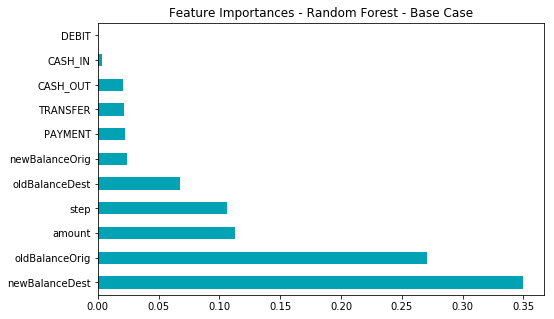

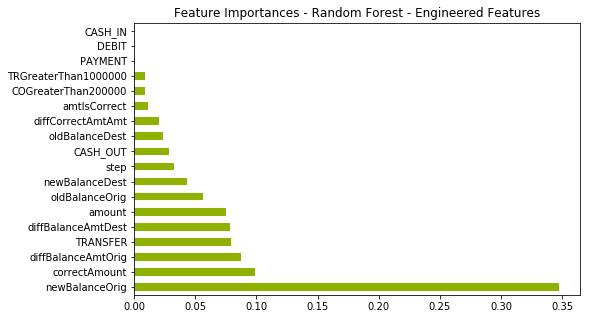

In [50]:
plt.rcParams['figure.figsize'] = [8, 5]
(pd.Series(RF_model_os_num_BC.feature_importances_,index=cols_x_num_BC)
    .nlargest(25)
    .plot(kind='barh',color='#00a2b3',title='Feature Importances - Random Forest - Base Case'))
plt.show();
plt.rcParams['figure.figsize'] = [8, 5]
(pd.Series(RF_model_os_num.feature_importances_,index=cols_x_num)
    .nlargest(25)
    .plot(kind='barh',color='#8fb202',title='Feature Importances - Random Forest - Engineered Features'))
plt.show();

## XGBoost

Boosting is a sequential technique which works on the principle of an ensemble of base models (decision trees used in this case). It combines a set of weak learners and delivers improved prediction accuracy due to giving higher weight to misclassified cases and lower weight to correctly classified entries. A weak learner is a model being slightly better than random guessing, e.g. a decision tree whose predictions are slightly better than 50%.

Below are results of XGBoost model using Base case scenario.

In [51]:
# pip install xgboost
import xgboost as xgb
from xgboost import XGBClassifier 
XGB_model_os_num_BC = XGBClassifier(n_estimators=100)
XGB_model_os_num_BC.fit(x_train_os_num_BC,y_train_os_num_BC)

train_accuracy = round(XGB_model_os_num_BC.score(x_train_os_num_BC,y_train_os_num_BC)*100,2)
train_precision = round(metrics.precision_score(y_train_os_num_BC,XGB_model_os_num_BC.predict(x_train_os_num_BC))*100,2)
train_recall = round(metrics.recall_score(y_train_os_num_BC,XGB_model_os_num_BC.predict(x_train_os_num_BC))*100,2)
train_F1_score = round(metrics.f1_score(y_train_os_num_BC,XGB_model_os_num_BC.predict(x_train_os_num_BC))*100,2)
train_AUPRC = round(metrics.average_precision_score(y_train_os_num_BC,XGB_model_os_num_BC.predict(x_train_os_num_BC))*100,2)

test_accuracy = round(XGB_model_os_num_BC.score(x_test_os_num_BC,y_test_os_num_BC)*100,2)
test_precision = round(metrics.precision_score(y_test_os_num_BC,XGB_model_os_num_BC.predict(x_test_os_num_BC))*100,2)
test_recall = round(metrics.recall_score(y_test_os_num_BC,XGB_model_os_num_BC.predict(x_test_os_num_BC))*100,2)
test_F1_score = round(metrics.f1_score(y_test_os_num_BC,XGB_model_os_num_BC.predict(x_test_os_num_BC))*100,2)
test_AUPRC = round(metrics.average_precision_score(y_test_os_num_BC,XGB_model_os_num_BC.predict(x_test_os_num_BC))*100,2)

# fill a list with train/test/validation results
results_train = ['XGB_model_num_BC','train',x_train_os_num_BC.shape[0],0,0,0,train_accuracy,train_precision,train_recall,\
                 train_F1_score,train_AUPRC,x_train_os_num_BC.columns]
results_test = ['XGB_model_num_BC','test',x_test_os_num_BC.shape[0],0,0,0,test_accuracy,test_precision,test_recall,\
                test_F1_score,test_AUPRC,x_test_os_num_BC.columns]
# turn list into a np.array, then to a DF
results_train_df = pd.DataFrame(np.array(results_train).reshape(1,-1),columns=final_results_table.columns)
results_test_df = pd.DataFrame(np.array(results_test).reshape(1,-1),columns=final_results_table.columns)
# concatenate to results_table
final_results_table = pd.concat([final_results_table,results_train_df,results_test_df],axis=0,ignore_index=True)
# display newly added rows of results_table
display(final_results_table.tail(2))
print(f'{metrics.confusion_matrix(y_test_os_num_BC,XGB_model_os_num_BC.predict(x_test_os_num_BC))}')

,Model,Train/Test,DataSize,OverSamp_Train,OverSamp_Test,EncodedCP,Accuracy,Precision,Recall,F1Score,AUPRC,Features
4,XGB_model_num_BC,train,477196,0,0,0,99.96,99.55,71.92,83.51,71.63,"Index(['step', 'amount', 'oldBalanceOrig', 'ne..."
5,XGB_model_num_BC,test,159066,0,0,0,99.96,97.24,68.78,80.57,66.92,"Index(['step', 'amount', 'oldBalanceOrig', 'ne..."


[[158857      4]
 [    64    141]]


In [52]:
pkl_filename = 'c:/MSI/BrainStation/Data Science FT/Capstone project/XGB_num_BC_10pc_diffCorrAmtAmt_CO_TR_no_validation.pkl'
#pkl_filename = 'c:/MSI/BrainStation/Data Science FT/Capstone project/XGB_num_BC_10pc_diffCorrAmtAmt_CO_TR_no_validation_100pct.pkl'

In [53]:
import pickle
# Save the model to local folder
pickle.dump(XGB_model_os_num_BC, open(pkl_filename, 'wb'))

In [54]:
# Load the model from file later
XGB_model_os_num_BC = pickle.load(open(pkl_filename, 'rb'))
metrics.confusion_matrix(y_test_os_num_BC,XGB_model_os_num_BC.predict(x_test_os_num_BC))

array([[158857,      4],
       [    64,    141]], dtype=int64)

In [55]:
# scenario with additional 7 features
import xgboost as xgb
from xgboost import XGBClassifier 
XGB_model_os_num = XGBClassifier(n_estimators=100)
XGB_model_os_num.fit(x_train_os_num,y_train_os_num)

train_accuracy = round(XGB_model_os_num.score(x_train_os_num,y_train_os_num)*100,2)
train_precision = round(metrics.precision_score(y_train_os_num,XGB_model_os_num.predict(x_train_os_num))*100,2)
train_recall = round(metrics.recall_score(y_train_os_num,XGB_model_os_num.predict(x_train_os_num))*100,2)
train_F1_score = round(metrics.f1_score(y_train_os_num,XGB_model_os_num.predict(x_train_os_num))*100,2)
train_AUPRC = round(metrics.average_precision_score(y_train_os_num,XGB_model_os_num.predict(x_train_os_num))*100,2)

test_accuracy = round(XGB_model_os_num.score(x_test_os_num,y_test_os_num)*100,2)
test_precision = round(metrics.precision_score(y_test_os_num,XGB_model_os_num.predict(x_test_os_num))*100,2)
test_recall = round(metrics.recall_score(y_test_os_num,XGB_model_os_num.predict(x_test_os_num))*100,2)
test_F1_score = round(metrics.f1_score(y_test_os_num,XGB_model_os_num.predict(x_test_os_num))*100,2)
test_AUPRC = round(metrics.average_precision_score(y_test_os_num,XGB_model_os_num.predict(x_test_os_num))*100,2)

# fill a list with train/test results
results_train = ['XGB_model_num','train',x_train_os_num.shape[0],0,0,0,train_accuracy,train_precision,train_recall,\
                 train_F1_score,train_AUPRC,x_train_os_num.columns]
results_test = ['XGB_model_num','test',x_test_os_num.shape[0],0,0,0,test_accuracy,test_precision,test_recall,test_F1_score,\
                test_AUPRC,x_test_os_num.columns]
# turn list into a np.array, then to a DF
results_train_df = pd.DataFrame(np.array(results_train).reshape(1,-1),columns=final_results_table.columns)
results_test_df = pd.DataFrame(np.array(results_test).reshape(1,-1),columns=final_results_table.columns)
# concatenate to results_table
final_results_table = pd.concat([final_results_table,results_train_df,results_test_df],axis=0,ignore_index=True)
# display newly added rows of results_table
display(final_results_table.tail(2))
print(f'{metrics.confusion_matrix(y_test_os_num,XGB_model_os_num.predict(x_test_os_num))}')

,Model,Train/Test,DataSize,OverSamp_Train,OverSamp_Test,EncodedCP,Accuracy,Precision,Recall,F1Score,AUPRC,Features
6,XGB_model_num,train,477196,0,0,0,100,99.67,99.51,99.59,99.19,"Index(['step', 'amount', 'oldBalanceOrig', 'ne..."
7,XGB_model_num,test,159066,0,0,0,100,99.03,100,99.51,99.03,"Index(['step', 'amount', 'oldBalanceOrig', 'ne..."


[[158859      2]
 [     0    205]]


The type of misclassification is rather positive in this case when the model is more conservative and classified two cases as being fraudulent when they are not. The implication in real life would be probably blocking such transactions. It is assumed that payment service provider would like to avoid such misclassifications not to create unnecessary friction during customer's shopping experience. 

In [56]:
pkl_filename = 'c:/MSI/BrainStation/Data Science FT/Capstone project/XGB_num_10pc_5features_diffCorrAmtAmt_CO_TR_no_validation.pkl'

In [57]:
import pickle
# Save the model to my folder
pickle.dump(XGB_model_os_num, open(pkl_filename, 'wb'))

In [58]:
# Load the model from file later
XGB_model_os_num = pickle.load(open(pkl_filename, 'rb'))
metrics.confusion_matrix(y_test_os_num,XGB_model_os_num.predict(x_test_os_num))

array([[158859,      2],
       [     0,    205]], dtype=int64)

In [59]:
final_results_table.to_csv('c:/MSI/BrainStation/Data Science FT/Capstone project/final_results_table.csv',sep=';')

In [60]:
# results on 10% of the data
final_results_table = pd.read_csv('c:/MSI/BrainStation/Data Science FT/Capstone project/final_results_table.csv',index_col=0,sep=';')
final_results_table.head()
fin = final_results_table.loc[[5,7],:]
fin = fin.drop(columns=['Features','Train/Test','DataSize','OverSamp_Train','OverSamp_Test','EncodedCP'])
display(fin)

,Model,Accuracy,Precision,Recall,F1Score,AUPRC
5,XGB_model_num_BC,99.96,97.24,68.78,80.57,66.92
7,XGB_model_num,100.00,99.03,100.00,99.51,99.03


For comparison, the below table shows the results for the initial train 75%/test 15%/validation 10% split before hyperparameters' tuning for a 10%, 80% subset of data and for the full 100% of data. Also, the respective confusion matrices are displayed. It wasn't feasible to run the tests again on the 75:25 split and on the 100% of the data due to computational capacity.  

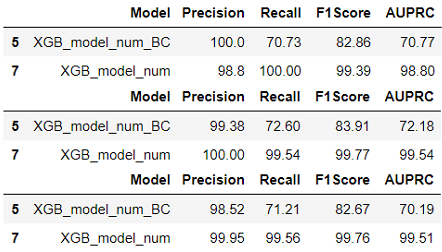

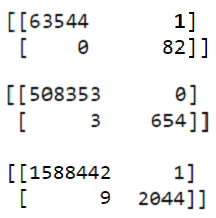

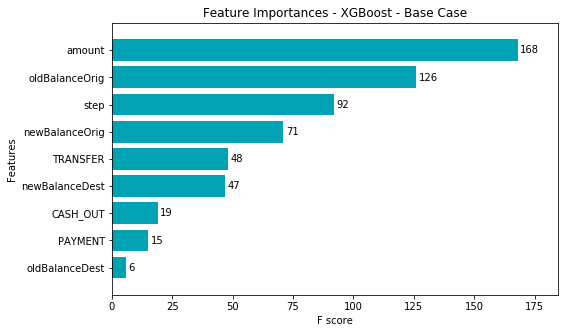

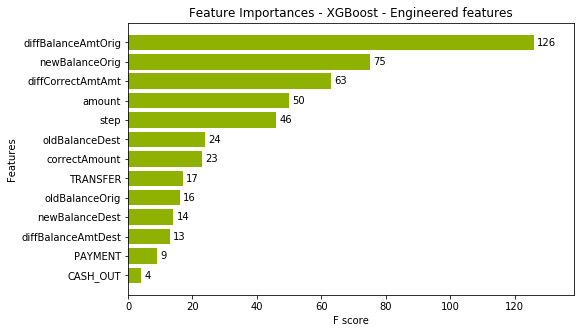

In [61]:
# visualizing the importance of features using bar graph
plt.rcParams['figure.figsize'] = [8, 5]
xgb.plot_importance(XGB_model_os_num_BC,grid=False, height=0.8,color='#00a2b3',title='Feature Importances - XGBoost - Base Case')
plt.show();
plt.rcParams['figure.figsize'] = [8, 5]
xgb.plot_importance(XGB_model_os_num,grid=False, height=0.8,color='#8fb202',title='Feature Importances - XGBoost - Engineered features')
plt.show();

The Base case feature importance graph shows that the model pays higher attention to the balances of originator of the transaction than to balances of the recipient. The assumption that distinguishing the sources of discrepancies between the *difference in balances* and the *reported amount* could have an impact on the decisions of the model has proven to be correct.  

In [62]:
fraudulent = ps_subset_amt[ps_subset_amt['isFraud']==1]
genuine = ps_subset_amt[ps_subset_amt['isFraud']==0]

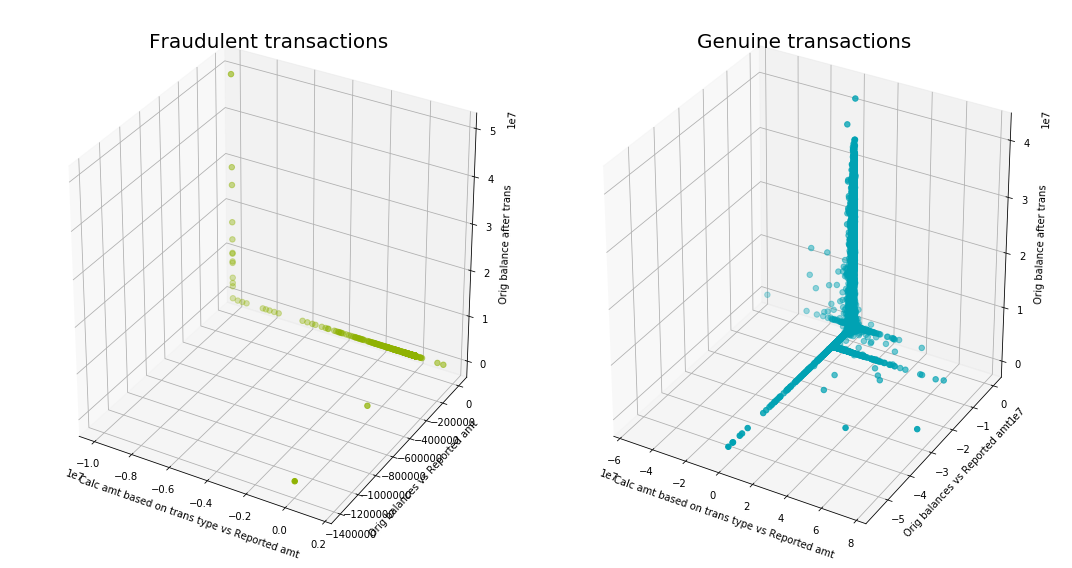

In [129]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(121,projection='3d')
ax1.scatter(fraudulent['diffCorrectAmtAmt'],fraudulent['diffBalanceAmtOrig'],fraudulent['newBalanceOrig'],c='#8fb202',s=30)
ax2 = fig.add_subplot(122,projection='3d')
ax2.scatter(genuine['diffCorrectAmtAmt'],genuine['diffBalanceAmtOrig'],genuine['newBalanceOrig'],c='#00a2b3',s=30)
ax1.set_xlabel('Calc amt based on trans type vs Reported amt'); 
ax1.set_ylabel('Orig balances vs Reported amt'); 
ax1.set_zlabel('Orig balance after trans')
ax1.set_title('Fraudulent transactions', size = 20)
ax2.set_xlabel('Calc amt based on trans type vs Reported amt'); 
ax2.set_ylabel('Orig balances vs Reported amt'); 
ax2.set_zlabel('Orig balance after trans')
ax2.set_title('Genuine transactions',size=20)
plt.tight_layout()
plt.show()

While Originator's balance after transaction (z axis) equals to zero in most cases for fraud cases (the fraudster either transfers or cashes out the entire balance available), it varies greatly for genuine transactions. The number of cases where the new balance is not equal to zero somewhat corresponds to the difference in number of transfer (408) and cash-out (415) fraud cases from the pie-chart in EDA.  

Since the entire account balance is being defrauded, the reported amount equals to the difference between the old and the new balance for fraudulent transactions (y axis). 

## Tuning Best Models' Hyperparameters  

Both of the top two models had comparable results for their engineered scenarios with additional 7 features. When looking for the best hyperparameters in order to maximize performance of the model, the search will be conducted for both, an XGBoost model as well as for a Random Forest model. 

In [63]:
from sklearn import pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from tempfile import mkdtemp
cachedir = mkdtemp()

estimators = [('model', XGBClassifier())] 

# saving results to temporary cache to speed up the process
pipe = pipeline.Pipeline(estimators, memory = cachedir)

# passing HP as a list of dictionaries (the order doesn't matter here)
param_grid = [
# first model's HP
{'model': [XGBClassifier()], 
 'model__max_depth': [5,10],
 'model__learning_rate': [0.1,0.15,0.2],
 'model__n_estimators': [50,75,100],
 'model__n_jobs': [4]},
# second model's HP
{'model': [RandomForestClassifier()],
 'model__n_estimators': [50,75,100],
 'model__n_jobs': [4]}]
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=38)
# specifying the n_jobs in the GridSearchCV to split the search into various branches and decrease the runtime for 
# finding the best combination of hyperparameters
grid = GridSearchCV(pipe, param_grid, cv=kfold,n_jobs=4,refit='f1',scoring=['balanced_accuracy','precision','recall',\
                                                                            'f1','average_precision'])
grid_fit = grid.fit(x_train_os_num, y_train_os_num)

In [64]:
import pickle
# define file name and path to local folder
pkl_filename = 'c:/MSI/BrainStation/Data Science FT/Capstone project/grid_search_fit_10pc_5features_no_validation.pkl'

In [59]:
# save the model to local folder
pickle.dump(grid_fit, open(pkl_filename, 'wb'))

In [65]:
# Load the model from file later
grid_fit = pickle.load(open(pkl_filename, 'rb'))

In [66]:
grid_search_results = pd.DataFrame(grid_fit.cv_results_)
grid_search_results = grid_search_results.loc[:,['mean_fit_time','mean_score_time','param_model','param_model__learning_rate','param_model__max_depth','param_model__n_estimators','param_model__n_jobs','param_model__min_samples_leaf','mean_test_balanced_accuracy','rank_test_balanced_accuracy','mean_test_average_precision','rank_test_average_precision','mean_test_f1','rank_test_f1','mean_test_precision','rank_test_precision','mean_test_recall','rank_test_recall']]
grid_search_results.sort_values(['rank_test_f1','rank_test_average_precision','mean_fit_time'],ascending=True).head()

,mean_fit_time,mean_score_time,param_model,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__n_jobs,param_model__min_samples_leaf,mean_test_balanced_accuracy,rank_test_balanced_accuracy,mean_test_average_precision,rank_test_average_precision,mean_test_f1,rank_test_f1,mean_test_precision,rank_test_precision,mean_test_recall,rank_test_recall
6,85.300719,5.669039,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.15,5,50,4,NaN,0.997563,1,0.994456,17,0.995941,1,0.996764,3,0.995130,1
0,95.472579,6.717048,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.1,5,50,4,NaN,0.997563,1,0.993234,20,0.995941,1,0.996764,3,0.995130,1
13,109.869239,6.405687,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.2,5,75,4,NaN,0.996754,3,0.994891,4,0.995126,3,0.996764,3,0.993512,3
16,111.553535,6.016206,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.2,10,75,4,NaN,0.996754,3,0.994837,5,0.995126,3,0.996764,3,0.993512,3
7,116.371809,5.906868,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.15,5,75,4,NaN,0.996754,3,0.994835,6,0.995126,3,0.996764,3,0.993512,3


In [62]:
grid_search_results.to_csv('c:/MSI/BrainStation/Data Science FT/Capstone project/grid_search_results_10pct_AUPRC_5features_final.csv',sep=';')

In [67]:
grid_fit.best_estimator_

Pipeline(memory='C:\\Users\\MARKTK~1\\AppData\\Local\\Temp\\tmpo8o2t_g9',
     steps=[('model', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=nan, n_estimators=50,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [68]:
best_model = grid_fit.best_estimator_
test_accuracy = round(metrics.balanced_accuracy_score(y_test_os_num,best_model.predict(x_test_os_num))*100,2)
test_precision = round(metrics.precision_score(y_test_os_num,best_model.predict(x_test_os_num))*100,2)
test_recall = round(metrics.recall_score(y_test_os_num,best_model.predict(x_test_os_num))*100,2)
test_F1_score = round(metrics.f1_score(y_test_os_num,best_model.predict(x_test_os_num))*100,2)
test_AUPRC = round(metrics.average_precision_score(y_test_os_num,best_model.predict(x_test_os_num))*100,2)
print(f'Test Accuracy score: {test_accuracy} %')
print(f'Test Precision score: {test_precision} %')
print(f'Test Recall score: {test_recall} %')
print(f'Test F1 score: {test_F1_score} %')
print(f'Test AUPRC: {test_AUPRC} %')
print()
print(f'Confusion matrix:')
print(metrics.confusion_matrix(y_test_os_num, best_model.predict(x_test_os_num)))

Test Accuracy score: 100.0 %
Test Precision score: 99.03 %
Test Recall score: 100.0 %
Test F1 score: 99.51 %
Test AUPRC: 99.03 %

Confusion matrix:
[[158859      2]
 [     0    205]]


The cross-validation grid search shows that the best hyperparameters were already used for train purposes because the predictions haven't improved.  

## AUPRC

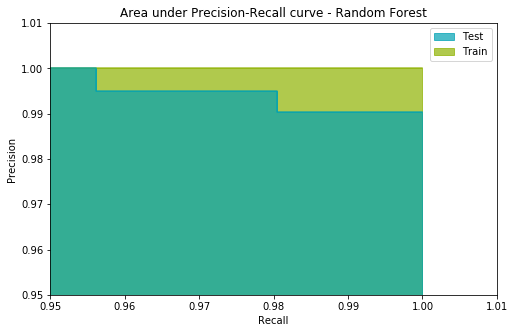

In [76]:
from sklearn.utils.fixes import signature
proba_train_RF = RF_model_os_num.predict_proba(x_train_os_num) 
proba_test_RF = RF_model_os_num.predict_proba(x_test_os_num) 
precision_train, recall_train, _ = metrics.precision_recall_curve(y_train_os_num, proba_train_RF[:, 1]) 
precision_test, recall_test, _ = metrics.precision_recall_curve(y_test_os_num, proba_test_RF[:, 1]) 

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
fig2 = plt.step(recall_train, precision_train, color='#8fb202', alpha=0.8,where='post')
fig2 = plt.fill_between(recall_train, precision_train, alpha=0.7, color='#8fb202',step='post')
fig1 = plt.step(recall_test, precision_test, color='#00a2b3', alpha=0.8,where='post')
fig1 = plt.fill_between(recall_test, precision_test, alpha=0.7, color='#00a2b3',step='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.95, 1.01])
plt.xlim([0.95, 1.01])
plt.legend((fig1,fig2),('Test','Train'))
plt.title('Area under Precision-Recall curve - Random Forest');

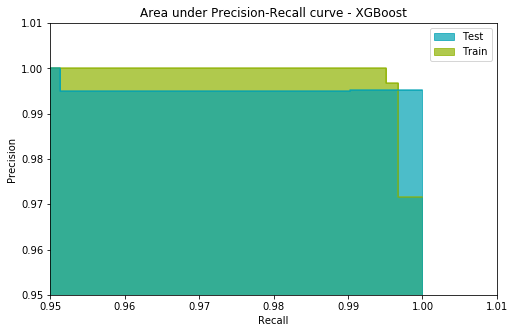

In [77]:
proba_train_XGB = XGB_model_os_num.predict_proba(x_train_os_num) 
proba_test_XGB = XGB_model_os_num.predict_proba(x_test_os_num) 
precision_train, recall_train, _ = metrics.precision_recall_curve(y_train_os_num, proba_train_XGB[:, 1]) 
precision_test, recall_test, _ = metrics.precision_recall_curve(y_test_os_num, proba_test_XGB[:, 1]) 

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
fig2 = plt.step(recall_train, precision_train, color='#8fb202', alpha=0.8,where='post')
fig2 = plt.fill_between(recall_train, precision_train, alpha=0.7, color='#8fb202',step='post')
fig1 = plt.step(recall_test, precision_test, color='#00a2b3', alpha=0.8,where='post')
fig1 = plt.fill_between(recall_test, precision_test, alpha=0.7, color='#00a2b3',step='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.95, 1.01])
plt.xlim([0.95, 1.01])
plt.legend((fig1,fig2),('Test','Train'))
plt.title('Area under Precision-Recall curve - XGBoost');

The Area under the Precision-Recall Curve (AUPRC) has an intention to show the trade-off needed when trying to maximize particular metric.  

## Conclusion

The best two models for detecting and predicting fraudulent transactions proved to be Random Forest and XGBoost with a Decision Tree as a base model. While reaching close-to-100% levels of F1 score, Precision, Recall and AUPRC, the interpretability of the model is not so straight-forward. The next steps would be to use ideally SHAP package that consistently evaluates the feature importance while not depending on the order in which the features were added/evaluated or how deep in the decision tree are they positioned. The interpretability of the model is one of the key aspects of model validation framework whose intention is, among other, to check whether a model being used by financial institution or a provider of behavioral solution services is compliant with anti-discrimination laws.  